In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize R^2 score dictionary
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}

valid_target_properties = []

In [2]:
# target_property_list = ['voltage', 'energy', 'conductivity', 'columbic_efficiency']
# target_property_list = ['voltage', 'energy', 'conductivity', 'capacity', 'columbic_efficiency']
target_property_list = ['voltage']

In [3]:
gnn_data = pd.read_csv(f'GNN_embedding/data0.csv')

In [4]:
text_data=pd.read_csv(f'text_embedding/embeddings_matbert-base-cased_robo_75966.csv')
text_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [5]:

joint_emb_data = pd.merge(gnn_data, text_data, on='id', suffixes=('_gnn', '_text'))

In [6]:
joint_emb_data

,0_gnn,1_gnn,2_gnn,3_gnn,4_gnn,5_gnn,6_gnn,7_gnn,8_gnn,9_gnn,...,758_text,759_text,760_text,761_text,762_text,763_text,764_text,765_text,766_text,767_text
0,-0.108516,-0.188924,0.082781,-0.073389,-0.007701,-0.032674,-0.015628,0.421225,-0.118788,0.037186,...,0.258880,-0.625149,-0.326193,0.280805,0.702279,0.808923,-0.405214,-0.233055,0.595055,0.017204
1,-0.046318,0.562878,0.055698,0.205902,-0.029210,-0.022339,-0.043030,-0.174005,0.390144,-0.006033,...,0.220329,-0.622529,-0.534220,0.225903,0.394166,0.903284,-0.333338,-0.000826,0.891638,0.054379
2,0.285167,-0.810647,0.090567,-0.251271,-0.119967,-0.044242,0.005363,0.260742,-0.011057,-0.081524,...,0.100956,-0.091720,-0.689677,0.047914,-0.007309,0.919780,-0.355693,0.352208,0.450927,-0.146104
3,0.062547,-0.430654,0.026547,-0.148377,0.124397,0.100217,0.038125,0.438710,0.269148,-0.063316,...,0.133492,-0.606550,-0.260574,0.123547,0.210020,1.086934,-0.480574,0.020664,0.949451,0.165641
4,-0.134846,0.443653,0.000987,-0.087407,-0.061124,0.070635,0.032104,0.772243,-0.473615,0.021064,...,0.073815,-0.652728,-0.449341,0.429638,0.280334,0.951851,-0.424798,-0.101823,0.850338,-0.006913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75961,0.011679,-0.518017,-0.129991,0.011976,0.107530,0.002103,-0.018547,0.101443,-0.145245,-0.105998,...,0.194026,-0.805831,-0.330715,0.377908,0.563158,0.749369,-0.317964,-0.189388,0.801970,0.006555
75962,-0.092684,-0.638890,0.085455,-0.362328,0.062571,-0.047454,-0.039646,0.134674,-0.135084,-0.063635,...,0.302705,-0.557138,-0.512698,0.270278,0.565966,0.913206,-0.174530,-0.000812,0.733439,-0.015745
75963,-0.038857,-0.325489,0.021810,-0.115585,0.107480,-0.015793,0.004674,0.837940,0.268215,-0.017907,...,0.256030,-0.758651,-0.270560,0.234898,0.461572,0.816908,-0.407951,-0.131478,0.853401,-0.080667
75964,-0.173519,-0.291057,0.026274,-0.110959,-0.063835,-0.045822,-0.063437,0.832776,-0.324021,-0.014176,...,0.175862,-0.664810,-0.485839,0.306389,0.532216,0.858228,-0.450032,0.081728,0.829036,-0.027318


## Final Evaluation 

In [70]:
best_hyperparameters = {
    "n_estimators": 200,
    "min_samples_split": 5,
    "min_samples_leaf": 4,
    "max_features": 'sqrt',
    'max_depth': 30, 
    "criterion": 'absolute_error',
    'bootstrap': False
}

In [71]:
## K means evaluation (k=10)

kf = KFold(n_splits=10, shuffle=False)

df1 = pd.read_excel(f'data/voltage_2022.xlsx')

avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, joint_emb_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()


# Extract features and target
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values


# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)


Completed fold 0 with MAE 0.45995475607237546 and R^2 0.1341340912981035
Completed fold 1 with MAE 0.6097873115843624 and R^2 0.07676723524069573
Completed fold 2 with MAE 0.5558831323511516 and R^2 -0.06161306608457906
Completed fold 3 with MAE 0.5964857223234061 and R^2 0.22187484256387902
Completed fold 4 with MAE 0.709200602430729 and R^2 0.1870337563786434
Completed fold 5 with MAE 0.6978510779802596 and R^2 -0.004522280520843136
Completed fold 6 with MAE 0.5920038353959896 and R^2 0.2574519809142606
Completed fold 7 with MAE 0.49662914434144434 and R^2 0.2815226004222039
Completed fold 8 with MAE 0.6230148281710446 and R^2 0.1958449322798912
Completed fold 9 with MAE 0.5123209408867182 and R^2 0.1972535103476799


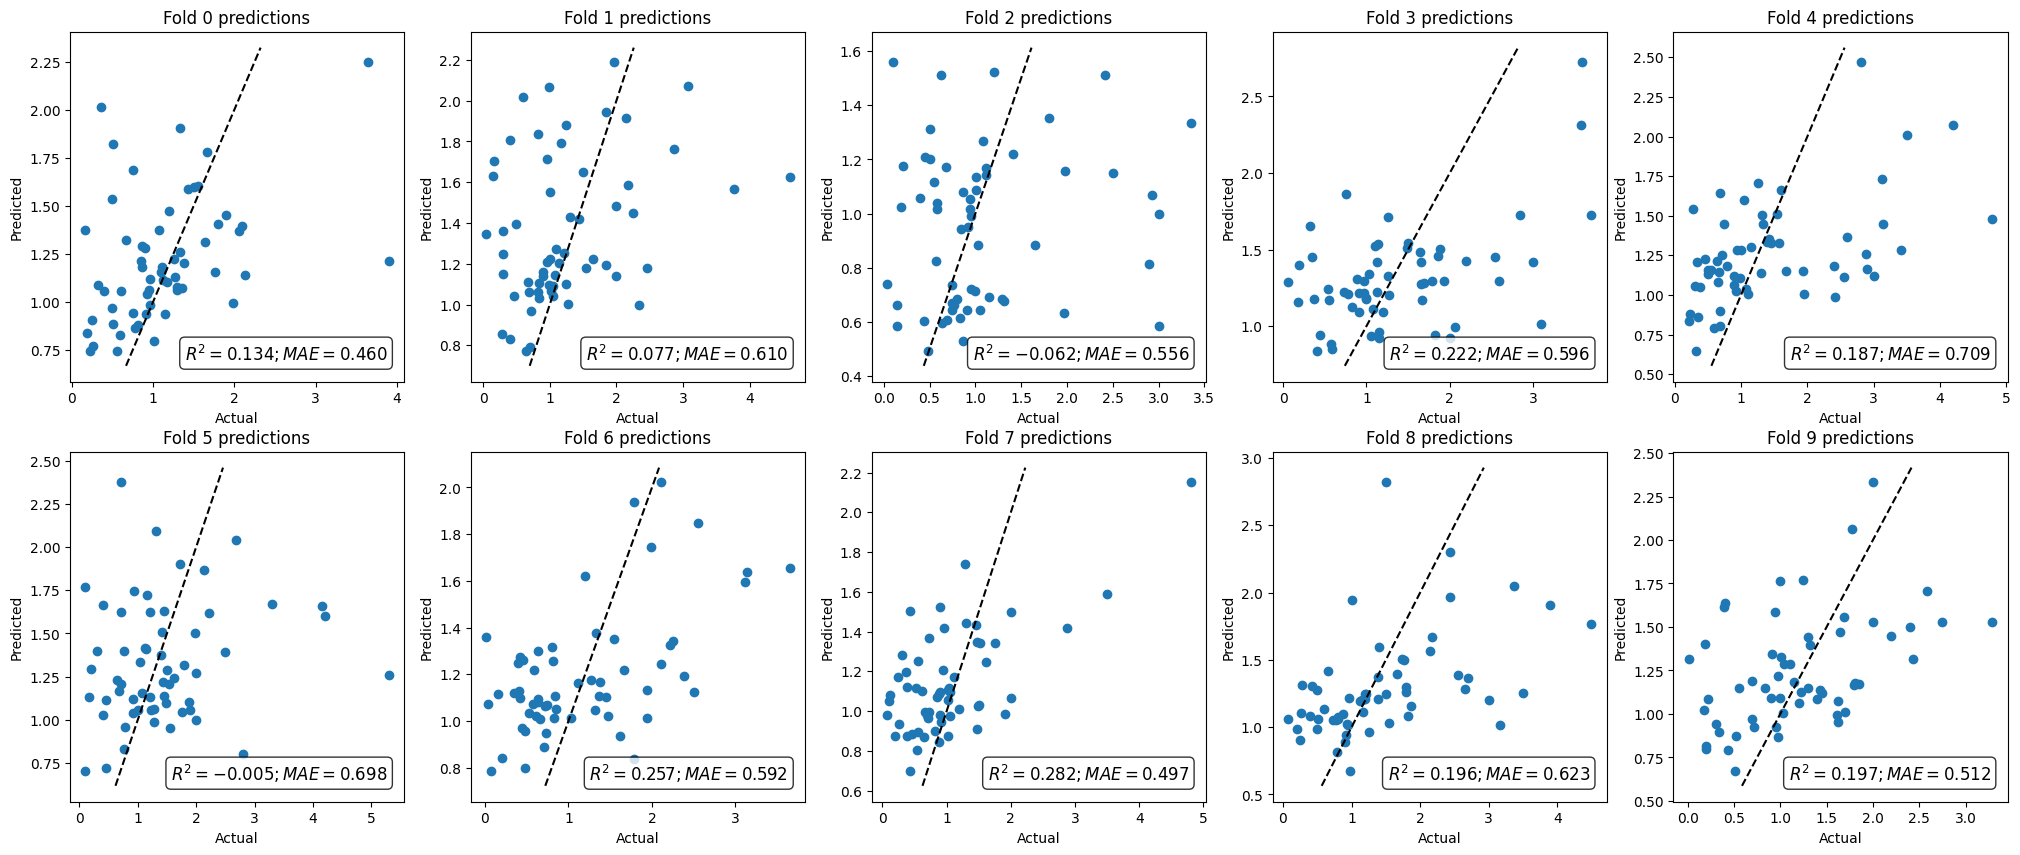

In [77]:
from sklearn.metrics import mean_squared_error

# Train and evaluate models
model = RandomForestRegressor(**best_hyperparameters, random_state=42)

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
plt.title("Text-only Optimized Model Prediction Performance")

fold_r2_accuracies = [] 
fold_mae_accuracies = [] 
fold_mse = []

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    fold_r2_accuracies.append(r2)

    mse = mean_squared_error(y_test, y_pred)
    fold_mse.append(mse)

    mae = mean_absolute_error(y_test, y_pred)
    fold_mae_accuracies.append(mae)

    current_ax = axes[int(fold >= 5)][fold % 5]

    current_ax.scatter(y_test, y_pred)
    current_ax.set_xlabel("Actual")
    current_ax.set_ylabel("Predicted")
    current_ax.set_title(f"Fold {fold} predictions")


    ## Adding x = y line 
    xmin, xmax = current_ax.get_xlim()
    ymin, ymax = current_ax.get_ylim()
    line_min = max(xmin, ymin)
    line_max = min(xmax, ymax)
    current_ax.plot([line_min, line_max], [line_min, line_max], 'k--', label='$x=y$')
    # current_ax.plot([1, 2], [1, 2], linestyle='--', color='gray', label='Ideal')

    current_ax.text(0.95, 0.05, f"$R^2 = {r2:.3f}; MAE = {mae:.3f}$",
                transform=current_ax.transAxes,
                fontsize=12,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


    print(f"Completed fold {fold} with MAE {mae} and R^2 {r2}")
plt.show()

In [73]:
np.mean(fold_mse)

0.6478082006191637

In [10]:
print("Target mean:", np.mean(y))
print("Target std:", np.std(y))
print("Range of y:", np.min(y), "-", np.max(y))

Target mean: 1.2546002699476035
Target std: 0.884357594569069
Range of y: 0.011499999999999967 - 5.300000000000001


## Data ablation study 

In [18]:
portions = [round(1 - 0.1 * i, 1) for i in range(10)]
portions

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

In [21]:
indices.shape

(587,)

In [ ]:
all_r2_accuracies  = {}
all_mae = {}

0.9 (528, 1536) (528,) -----------
Completed fold 0 with MAE 0.5331481790480315 and R^2 0.38275050884143147
Completed fold 1 with MAE 0.6771989101234696 and R^2 0.0797165537899781
Completed fold 2 with MAE 0.6679924777246463 and R^2 0.08219056606142372
Completed fold 3 with MAE 0.574015277964485 and R^2 0.028811954910978432
Completed fold 4 with MAE 0.6372712004860188 and R^2 0.1188926095539602
Completed fold 5 with MAE 0.5867716066795089 and R^2 0.22347136630688824
Completed fold 6 with MAE 0.5628769628426178 and R^2 -0.21740237898827064
Completed fold 7 with MAE 0.4787595511905013 and R^2 0.13991671702138997
Completed fold 8 with MAE 0.4488423607990839 and R^2 0.16586356435098915
Completed fold 9 with MAE 0.5504294437911217 and R^2 0.36947896931315816
0.8 (469, 1536) (469,) -----------
Completed fold 0 with MAE 0.5651827733260858 and R^2 0.37625872609994393
Completed fold 1 with MAE 0.6077176432937393 and R^2 0.0857550657429571
Completed fold 2 with MAE 0.704946193561016 and R^2 -0.0

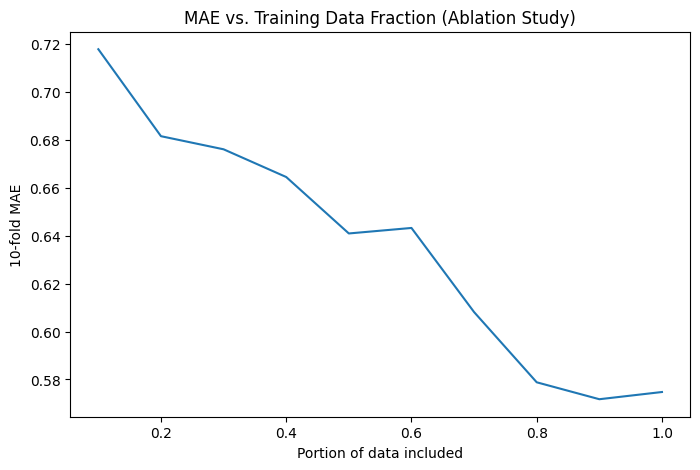

0.9 (528, 1536) (528,) -----------
Completed fold 0 with MAE 0.6589117396186964 and R^2 0.04737432705311584
Completed fold 1 with MAE 0.505552179286474 and R^2 0.04342803278510754
Completed fold 2 with MAE 0.497557670085058 and R^2 0.1430554983197364
Completed fold 3 with MAE 0.5543807685767208 and R^2 0.26806323405289256
Completed fold 4 with MAE 0.6025844395847665 and R^2 0.17875377914727553
Completed fold 5 with MAE 0.636757624452155 and R^2 0.1586618936718771
Completed fold 6 with MAE 0.5101488943491926 and R^2 0.28454226318808096
Completed fold 7 with MAE 0.6271768917329219 and R^2 0.14200592648302335
Completed fold 8 with MAE 0.5465716945028217 and R^2 0.22592922739308963
Completed fold 9 with MAE 0.6880428777709737 and R^2 0.13252419119697423
0.8 (469, 1536) (469,) -----------
Completed fold 0 with MAE 0.6555778245666642 and R^2 0.08280630822873092
Completed fold 1 with MAE 0.5216255474527131 and R^2 -0.0035100163329306877
Completed fold 2 with MAE 0.5486241401463561 and R^2 0.0

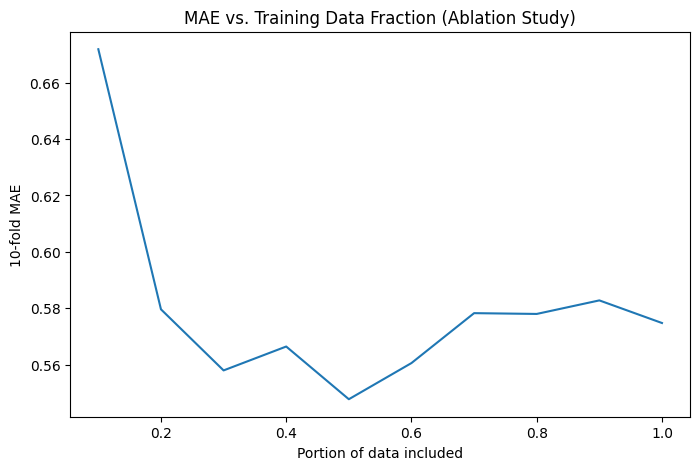

0.9 (528, 1536) (528,) -----------
Completed fold 0 with MAE 0.46931802777058945 and R^2 0.3459046206940142
Completed fold 1 with MAE 0.6577371765903541 and R^2 0.18195379701676262
Completed fold 2 with MAE 0.5426323005141906 and R^2 0.22712067031462946
Completed fold 3 with MAE 0.5137774342012363 and R^2 0.032965707768804475
Completed fold 4 with MAE 0.6079301914160633 and R^2 0.2865773778967158
Completed fold 5 with MAE 0.4992343353233346 and R^2 0.24529467933180815
Completed fold 6 with MAE 0.668446240873365 and R^2 -0.20976154907149458
Completed fold 7 with MAE 0.5434133044795274 and R^2 0.22741594781856878
Completed fold 8 with MAE 0.5583127168590118 and R^2 0.08098670608346015
Completed fold 9 with MAE 0.6012211559772211 and R^2 0.16956461491529262
0.8 (469, 1536) (469,) -----------
Completed fold 0 with MAE 0.4839734308853845 and R^2 0.3374373201461137
Completed fold 1 with MAE 0.5949232867739287 and R^2 0.21683426660264926
Completed fold 2 with MAE 0.5604893540827961 and R^2 0.

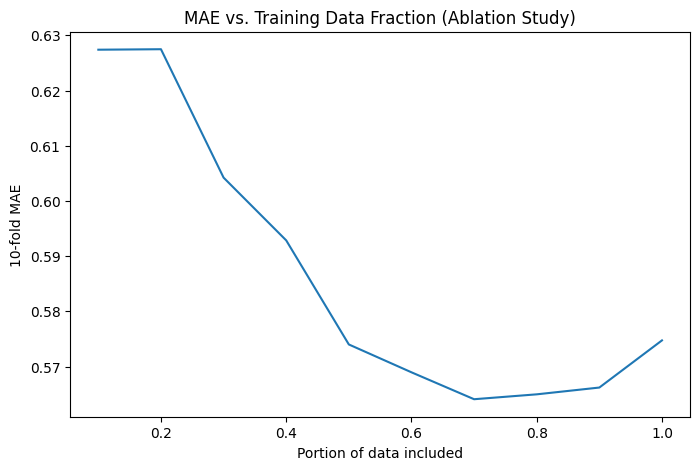

In [ ]:

# Train and evaluate models
model = RandomForestRegressor(**best_hyperparameters, random_state=42)

# fig, axes = plt.subplots(2, 5, figsize=(20, 10))
# plt.title("Text-only Optimized Model Prediction Performance")

fold_r2_accuracies = {}
fold_mae_accuracies = {} 

# for seed in [42, 0, 2, 5, 10, 15]:
for seed in [1, 3, 4]:
    np.random.seed(seed)
    indices = np.random.permutation(len(X))

    portions = [round(1 - 0.1 * i, 1) for i in range(10)]
    fold_r2_accuracies[1] = all_r2_accuracies[42][1]
    fold_mae_accuracies[1] = all_mae[42][1]

    for portion in portions[1:]:
        index_mask = indices[:int(len(indices) * portion)]

        X_portioned = X[index_mask]
        y_portioned = y[index_mask]
        print(portion, X_portioned.shape, y_portioned.shape, "-----------")

        fold_r2_accuracies[portion] = []
        fold_mae_accuracies[portion] = []

        for fold, (train_index, test_index) in enumerate(kf.split(X_portioned)):
            X_train, X_test = X_portioned[train_index], X_portioned[test_index]
            y_train, y_test = y_portioned[train_index], y_portioned[test_index]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies[portion].append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies[portion].append(mae)

            print(f"Completed fold {fold} with MAE {mae} and R^2 {r2}")


    all_r2_accuracies[seed] = fold_r2_accuracies
    all_mae[seed] = fold_mae_accuracies

    average_MAEs = [np.mean(all_mae[seed][portion]) for portion in portions]

    plt.figure(figsize=(8, 5))
    plt.plot(portions, average_MAEs)

    plt.xlabel("Portion of data included")
    plt.ylabel("10-fold MAE")
    plt.title("MAE vs. Training Data Fraction (Ablation Study)")
    plt.show()

In [55]:
all_mae[0]

{1.0: [0.6042856482199979,
  0.5401814540981326,
  0.5722720919125648,
  0.5399640051747052,
  0.6824734165257244,
  0.6787604965579397,
  0.6161726288660473,
  0.4735397864831138,
  0.5369068268105112,
  0.5529465491296696],
 0.9: [0.6053541107768987,
  0.5586228147549818,
  0.5608588564358199,
  0.6089910240312421,
  0.5704573742793891,
  0.7145717270824454,
  0.5890276077292609,
  0.6177606591674313,
  0.5070075946397518,
  0.5392871624466486],
 0.8: [0.6217619206239047,
  0.5892608565331716,
  0.46671770089028564,
  0.6161301430591557,
  0.5436712097598112,
  0.6904053368226988,
  0.7114069093474327,
  0.5887558723970503,
  0.6510966742575448,
  0.4419106770603497],
 0.7: [0.6299891539731428,
  0.6213732781856306,
  0.5135345440831272,
  0.5809680741997886,
  0.5993386806676645,
  0.5534560324517191,
  0.6903089751330728,
  0.7583336763067858,
  0.591244388555588,
  0.6449409966026186],
 0.6: [0.6930450841887646,
  0.5554060988804781,
  0.5587853892778001,
  0.48868023722937043,
  

In [59]:
all_mae_data

array([[0.5747434 , 0.57553619, 0.58175876, 0.58899564, 0.61689065,
        0.6308546 , 0.65308026, 0.60805094, 0.63861126, 0.7487314 ],
       [0.57975029, 0.58719389, 0.59211173, 0.61834878, 0.61868306,
        0.61405107, 0.58604316, 0.59743277, 0.62073136, 0.68996822],
       [0.580496  , 0.58206519, 0.5837907 , 0.59762288, 0.61426829,
        0.62851281, 0.66413673, 0.6392867 , 0.68307004, 0.71775628],
       [0.5747434 , 0.56620229, 0.56497244, 0.56408675, 0.56896168,
        0.57400578, 0.59285833, 0.60422552, 0.62748379, 0.62739641],
       [0.5747434 , 0.56620229, 0.56497244, 0.56408675, 0.56896168,
        0.57400578, 0.59285833, 0.60422552, 0.62748379, 0.62739641],
       [0.5747434 , 0.56620229, 0.56497244, 0.56408675, 0.56896168,
        0.57400578, 0.59285833, 0.60422552, 0.62748379, 0.62739641]])

In [69]:
import torch 

torch.save(all_mae_data, "joint_embedding_results/all_mae_data.pt")
torch.save(r2_all_data, "joint_embedding_results/r2_all_data.pt")

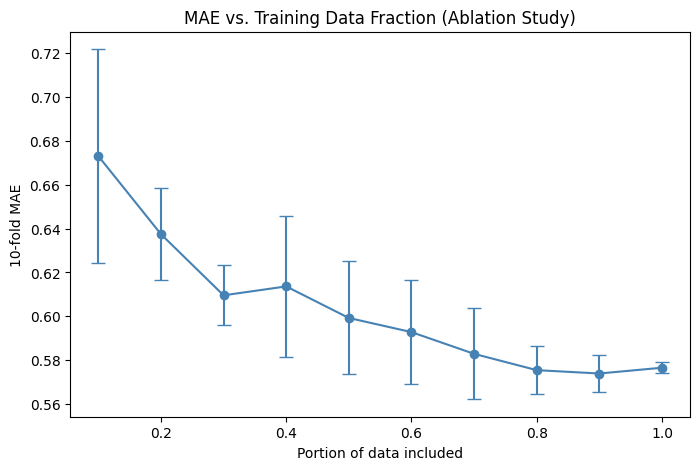

In [62]:
## Plot all of the MAE values 
all_mae_data = np.array([
    [np.mean(all_mae[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

means = all_mae_data.mean(axis=0)
stds = all_mae_data.std(axis=0)

plt.figure(figsize=(8, 5))
plt.errorbar(portions, means, yerr=stds, fmt='-o', capsize=5, color='steelblue')
plt.xlabel("Portion of data included")
plt.ylabel("10-fold MAE")
plt.title("MAE vs. Training Data Fraction (Ablation Study)")
# plt.tight_layout()
plt.show()

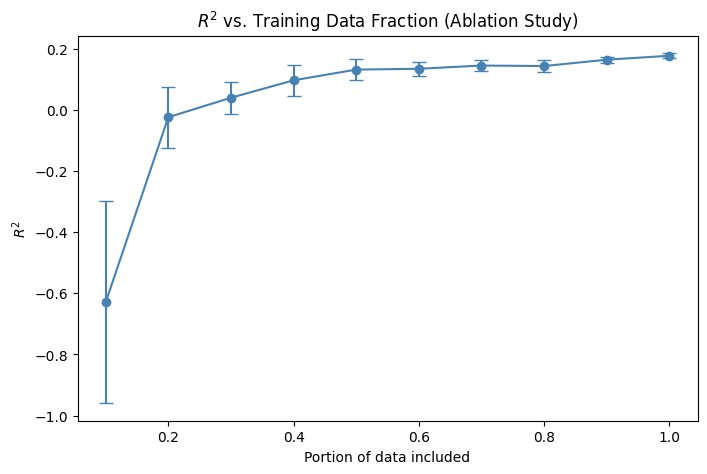

In [65]:
## Plot all of the MAE values 
r2_all_data = np.array([
    [np.mean(all_r2_accuracies[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

means = r2_all_data.mean(axis=0)
stds = r2_all_data.std(axis=0)

plt.figure(figsize=(8, 5))
plt.errorbar(portions, means, yerr=stds, fmt='-o', capsize=5, color='steelblue')
plt.xlabel("Portion of data included")
plt.ylabel(r'$R^2$')
plt.title(r'$R^2$ vs. Training Data Fraction (Ablation Study)')
# plt.tight_layout()
plt.show()

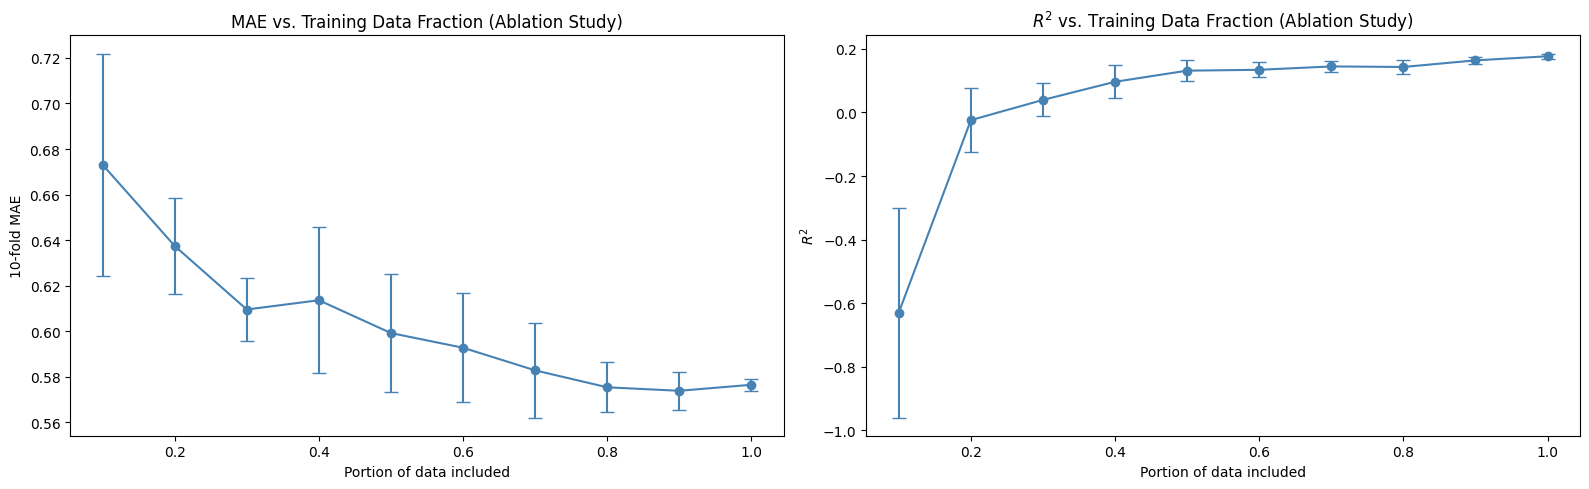

In [ ]:
import matplotlib.pyplot as plt

r2_all_data = np.array([
    [np.mean(all_r2_accuracies[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

all_mae_data = np.array([
    [np.mean(all_mae[seed][portion]) for portion in portions] for seed in all_mae.keys()
])

# Create a figure with 1 row and 2 columns for the subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: MAE vs. Training Data Fraction
axs[0].errorbar(portions, all_mae_data.mean(axis=0), yerr=all_mae_data.std(axis=0), fmt='-o', capsize=5, color='steelblue')
axs[0].set_xlabel("Portion of data included")
axs[0].set_ylabel("10-fold MAE")
axs[0].set_title("MAE vs. Training Data Fraction (Ablation Study)")

# Plot 2: R^2 vs. Training Data Fraction
axs[1].errorbar(portions, r2_all_data.mean(axis=0), yerr=r2_all_data.std(axis=0), fmt='-o', capsize=5, color='steelblue')
axs[1].set_xlabel("Portion of data included")
axs[1].set_ylabel(r'$R^2$')
axs[1].set_title(r'$R^2$ vs. Training Data Fraction (Ablation Study)')

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

Text(0.5, 1.0, 'MAE vs. Training Data Fraction (Ablation Study)')

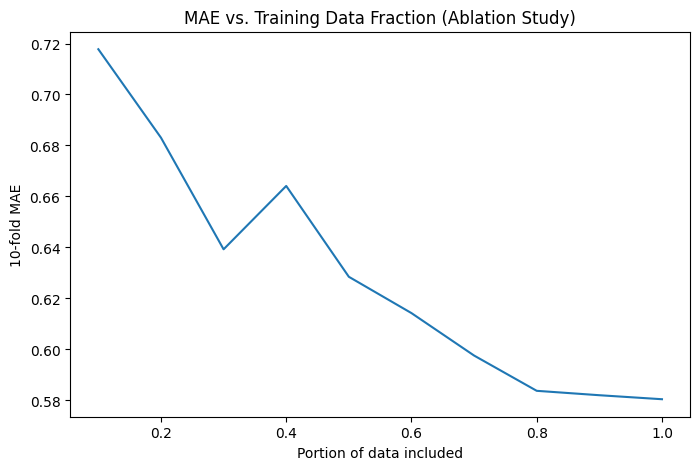

In [50]:
average_MAEs = [np.mean(all_mae[seed][portion]) for portion in portions]

plt.figure(figsize=(8, 5))
plt.plot(portions, average_MAEs)

plt.xlabel("Portion of data included")
plt.ylabel("10-fold MAE")
plt.title("MAE vs. Training Data Fraction (Ablation Study)")

Text(0.5, 1.0, 'MAE vs. Training Data Fraction (Ablation Study)')

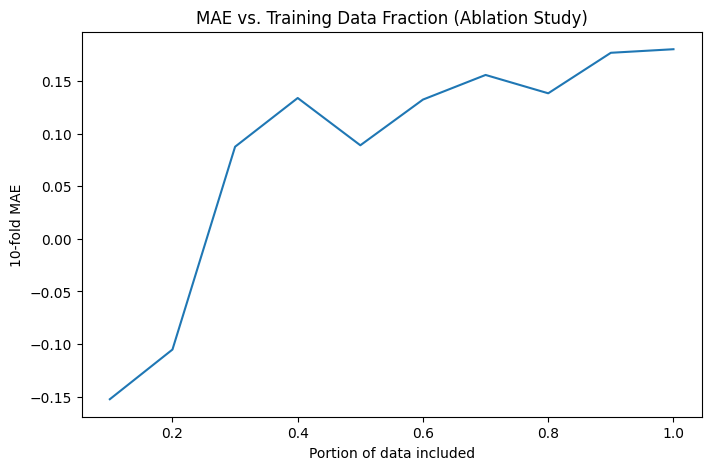

In [40]:
average_MAEs = [np.mean(all_r2_accuracies[42][portion]) for portion in portions]

plt.figure(figsize=(8, 5))
plt.plot(portions, average_MAEs)

plt.xlabel("Portion of data included")
plt.ylabel("10-fold MAE")
plt.title("MAE vs. Training Data Fraction (Ablation Study)")

## Three-model comparison plot

In [46]:
import numpy as np

# Data
categories = ['Graph-only', 'Text-only', 'Joint-embedding']
mae_values = [0.5859, 0.6121, 0.5853]
r2_values = [0.1558, 0.0685, 0.1486]

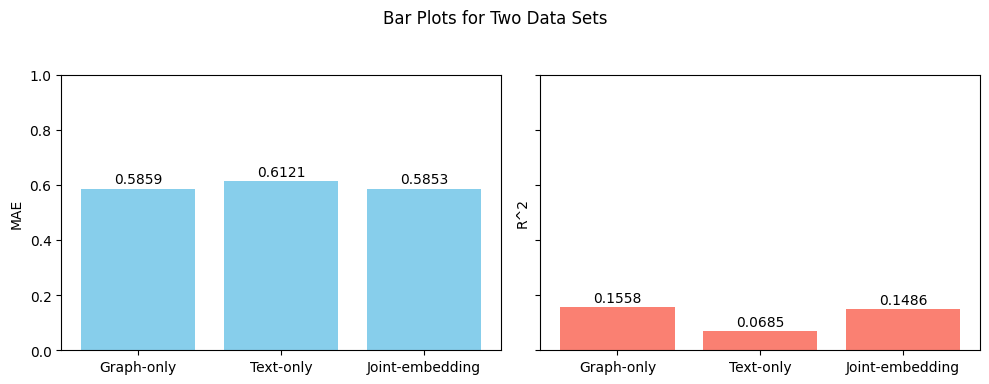

In [49]:
# Create subplots: one for each set of values
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# First plot
axes[0].bar(categories, mae_values, color='skyblue')
# axes[0].set_title('')
axes[0].set_ylabel('MAE')
# axes[0].set_ylim(1)

for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Second plot
axes[1].bar(categories, r2_values, color='salmon')
# axes[1].set_title('R^2')
axes[1].set_ylabel('R^2')
axes[1].set_ylim(0, 1)
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

fig.suptitle('Bar Plots for Two Data Sets')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
